# Grupo Dale Science
**Composto por:**
- Luã Greski Diel
- Rodrigo Aschidamini João
- Lorenzo Menezes Silveira
- Chrinovic Tshibambe Ngala
- Igor Morais Telles

## Sobre o Projeto

Este notebook está em desenvolvimento no **bootcamp em data science da BAH**, em parceria com a empresa **FINOR**. A tarefa envolve a criação de um modelo de **index tracking**, que busca reproduzir o comportamento de índices de ações com um número de ações inferior ao do índice original. Isso simplifica a composição do portfólio e reduz o custo de manutenção.

### Objetivo geral:
Desenvolver um modelo de index tracking para os índices **S&P100** e **IBOV**.

### Objetivo deste notebook:
Finalização do pré-processamento e a análise exploratória da base de dados.Seleção dos parâmetros que serão usados no modelo de minimização, reamostragens e previsões/inferências usando o modelo dado.

## Importação de Bibliotecas


In [ ]:
import pandas as pd               # Biblioteca para a manipulação de dados - Versão 2.2.2
import yfinance as yf             # Biblioteca para fazer o download dos dados do site Yahoo Finance - Versão 0.2.44
import matplotlib.pyplot as plt   # Biblioteca para Visualização de dados - versão 3.7.1
#import matplotlib
import seaborn as sns             # Biblioteca para Visualização de dados - versão 0.13.2
import numpy as np
# Necessário para os plots aparecerem automáticamente no Jupyter
%matplotlib inline


# instalação das versões usadas neste trabalho
#!pip install pandas==2.2.2
#!pip install yfinance==0.2.44
#!pip install matplotlib==3.7.1
#!pip install seaborn==0.13.2

# verificar as versões das bibliotecas
#pd.__version__
#yf.__version__
#matplotlib.__version__
#sns.__version__

Montando o Drive para importar os arquivos

# Instalacao e importacao do solver Guroby

In [ ]:
pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 82.8 MB/s eta 0:00:00


In [ ]:
import gurobipy as gp

Setando o ambiente


In [ ]:

params = {
"WLSACCESSID": 'd3c1dba9-29de-4b51-afc4-0275ff2c1fc4',
"WLSSECRET": '3de07af2-0c8b-456b-a57d-96a37df8fdf8',
"LICENSEID": 2588560,
}

env = gp.Env(params=params)

model = gp.Model(env=env)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2588560
Academic license 2588560 - for non-commercial use only - registered to 00___@ufrgs.br


## Leitura dos conjuntos de dados

Após o pré-processamento realizado na entrega 1, os conjuntos de dados abaixo apresentam os preços dos índices e dos ativos que os compõem. O período considerado vai de 18/10/2017 a 18/10/2024.

In [66]:
# Leitura dos dataframes dos índices
df_sp100 = pd.read_csv('sp100_dados.csv', parse_dates=['Date'])
df_bvsp = pd.read_csv('bvsp_dados.csv', parse_dates=['Date'])

# Leitura dos dataframes do ativos de cada índice
df_ativos_sp100 = pd.read_csv('sp100_ativos_hist.csv', parse_dates=['Date'])
df_ativos_bvsp = pd.read_csv('bvsp_ativos_hist.csv', parse_dates=['Date'])

# Checagem dos conjuntos
df_sp100.head()
#df_bvsp.head()
df_ativos_sp100.head()
#df_ativos_bvsp.head()

#df_sp100.dtypes
#df_bvsp.dtypes
#df_ativos_sp100.dtypes
#df_ativos_bvsp.dtypes

,Symbol,Date,Open,High,Low,Close,Adj Close,Volume
0,AAPL,2017-10-18,234.614247,235.038385,233.415009,233.648992,219.077171,65496800.0
1,AAPL,2017-10-19,229.246875,229.729503,226.716756,228.120744,213.893660,170336800.0
2,AAPL,2017-10-20,229.042126,230.709375,228.091510,228.515625,214.263882,95896400.0
3,AAPL,2017-10-23,229.451624,230.621629,227.418750,228.398622,214.154244,87937200.0
4,AAPL,2017-10-24,228.574115,230.226747,228.442496,229.758759,215.429513,71028800.0


In [ ]:
df_ativos_sp100.dtypes

,0
Symbol,object
Date,"datetime64[ns, UTC]"
Adj Close,object
Close,object
High,object
...,...
Close.104,object
High.104,object
Low.104,object
Open.104,object


Leitura do conjunto de dados pelo drive (sugestao pra nao precisar baixar os arquivos dos dados)


## Estatísticas descritivas

### S&P 100

In [ ]:
df_sp100_describe = df_sp100.describe().round(2).iloc[:, 1:6]

# Multiplicar apenas as linhas diferentes de 'count' pelo câmbio
df_sp100_reais = df_sp100_describe.copy()  # Criar uma cópia para modificar
df_sp100_reais.round(2)

,Open,High,Low,Close,Adj Close
count,1761.00,1761.00,1761.00,1761.00,1761.00
mean,1718.87,1729.19,1708.05,1719.24,1719.24
min,1048.70,1067.66,1015.63,1040.00,1040.00
25%,1289.25,1294.85,1283.00,1288.83,1288.83
50%,1734.84,1751.93,1722.37,1737.10,1737.10
75%,2034.40,2044.93,2022.62,2034.65,2034.65
max,2831.30,2832.23,2811.45,2818.50,2818.50
std,438.88,440.72,437.03,439.06,439.06


### IBOV

In [ ]:
df_bvsp.describe().round(2).iloc[:, 1:6]

,Open,High,Low,Close,Adj Close
count,1738.00,1738.00,1738.00,1738.00,1738.00
mean,105695.03,106634.64,104773.48,105724.48,105724.48
min,63604.00,67604.00,61691.00,63570.00,63570.00
25%,95863.00,96711.50,94810.75,95862.25,95862.25
50%,107602.00,108543.50,106646.50,107661.50,107661.50
75%,117864.00,118737.25,116899.25,117866.00,117866.00
max,137349.00,137469.00,136664.00,137344.00,137344.00
std,16430.42,16354.41,16491.64,16425.18,16425.18


### Ativos do S&P 100

In [ ]:
from random import sample

# Número de ativos sorteados
num_sorteados = 3

# Sorteio dos símbolos únicos do S&P 100
sp100_sorteados = sample(list(df_ativos_sp100['Symbol'].unique()), num_sorteados)

# Criar um dicionário para armazenar os describe separados
describes_separados = {}

for simbolo in sp100_sorteados:
    # Filtrar os dados do ativo atual
    df_ativo = df_ativos_sp100[df_ativos_sp100['Symbol'] == simbolo]

    # Calcular o describe e armazenar no dicionário
    describes_separados[simbolo] = df_ativo.describe().round(2)

# Exibir os describe separadamente
for simbolo, describe in describes_separados.items():
    print(f"Describe para o ativo {simbolo}:")
    print(describe.round(2).iloc[:, 1:6])
    print("\n")

Describe para o ativo WMT:
                                       Date Adj Close Close High  Low
count                                  1761         0     0    0    0
unique                                  NaN         0     0    0    0
top                                     NaN       NaN   NaN  NaN  NaN
freq                                    NaN       NaN   NaN  NaN  NaN
mean    2021-04-18 13:48:20.851788800+00:00       NaN   NaN  NaN  NaN
min               2017-10-18 00:00:00+00:00       NaN   NaN  NaN  NaN
25%               2019-07-22 00:00:00+00:00       NaN   NaN  NaN  NaN
50%               2021-04-20 00:00:00+00:00       NaN   NaN  NaN  NaN
75%               2023-01-18 00:00:00+00:00       NaN   NaN  NaN  NaN
max               2024-10-17 00:00:00+00:00       NaN   NaN  NaN  NaN


Describe para o ativo CAT:
                                       Date Adj Close Close High  Low
count                                  1761         0     0    0    0
unique                            

### Ativos IBOV

In [ ]:
from random import sample

# Número de ativos sorteados
num_sorteados = 3

# Sorteio dos símbolos únicos do S&P 100
bvsp_sorteados = sample(list(df_ativos_bvsp['Symbol'].unique()), num_sorteados)

# Criar um dicionário para armazenar os describe separados
describes_separados = {}

for simbolo in bvsp_sorteados:
    # Filtrar os dados do ativo atual
    df_ativo = df_ativos_bvsp[df_ativos_bvsp['Symbol'] == simbolo]

    # Calcular o describe e armazenar no dicionário
    describes_separados[simbolo] = df_ativo.describe().round(2)

# Exibir os describe separadamente
for simbolo, describe in describes_separados.items():
    print(f"Describe para o ativo {simbolo}:")
    print(describe.round(2).iloc[:, 1:6])
    print("\n")

Describe para o ativo BPAC11.SA:
                                       Date Adj Close Close High  Low
count                                  1743         0     0    0    0
unique                                  NaN         0     0    0    0
top                                     NaN       NaN   NaN  NaN  NaN
freq                                    NaN       NaN   NaN  NaN  NaN
mean    2021-04-21 03:33:58.554216960+00:00       NaN   NaN  NaN  NaN
min               2017-10-18 00:00:00+00:00       NaN   NaN  NaN  NaN
25%               2019-07-22 12:00:00+00:00       NaN   NaN  NaN  NaN
50%               2021-04-27 00:00:00+00:00       NaN   NaN  NaN  NaN
75%               2023-01-21 12:00:00+00:00       NaN   NaN  NaN  NaN
max               2024-10-17 00:00:00+00:00       NaN   NaN  NaN  NaN


Describe para o ativo AURE3.SA:
                                       Date Adj Close Close High  Low
count                                   643         0     0    0    0
unique                 

## Matriz de correlação

### Índices

In [69]:
df_sp100 = pd.read_csv('sp100_dados.csv', parse_dates=['Date'])
df_bvsp = pd.read_csv('bvsp_dados.csv', parse_dates=['Date'])

df_sp100.corr().round(4)
#df_bvsp.corr().round(4)

,Date,Open,High,Low,Close,Adj Close,Volume
Date,1.0000,0.9187,0.9207,0.9171,0.9190,0.9190,0.1186
Open,0.9187,1.0000,0.9998,0.9996,0.9993,0.9993,0.0307
High,0.9207,0.9998,1.0000,0.9995,0.9996,0.9996,0.0372
Low,0.9171,0.9996,0.9995,1.0000,0.9997,0.9997,0.0203
Close,0.9190,0.9993,0.9996,0.9997,1.0000,1.0000,0.0280
Adj Close,0.9190,0.9993,0.9996,0.9997,1.0000,1.0000,0.0280
Volume,0.1186,0.0307,0.0372,0.0203,0.0280,0.0280,1.0000


### Ativos S&P 100

In [ ]:
from random import sample
import pandas as pd

# Número de ativos sorteados
num_sorteados = 3

# Sorteio dos símbolos únicos do IBOVESPA
sp100_sorteados = sample(list(df_ativos_sp100['Symbol'].unique()), num_sorteados)

# Criar um dicionário para armazenar as matrizes de correlação separadas
matrizes_correlacao = {}

for simbolo in sp100_sorteados:
    # Filtrar os dados do ativo atual
    df_ativo = df_ativos_sp100[df_ativos_sp100['Symbol'] == simbolo]

    # Selecionar apenas as colunas numéricas relevantes
    df_numerico = df_ativo[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]

    # Calcular a matriz de correlação
    matriz_corr = df_numerico.corr()

    # Armazenar a matriz no dicionário
    matrizes_correlacao[simbolo] = matriz_corr

# Exibir as matrizes de correlação separadamente
for simbolo, matriz_corr in matrizes_correlacao.items():
    print(f"Matriz de Correlação para o ativo {simbolo}:")
    print(matriz_corr.round(4))
    print("\n")

Matriz de Correlação para o ativo JNJ:
           Open  High  Low  Close  Adj Close  Volume
Open        NaN   NaN  NaN    NaN        NaN     NaN
High        NaN   NaN  NaN    NaN        NaN     NaN
Low         NaN   NaN  NaN    NaN        NaN     NaN
Close       NaN   NaN  NaN    NaN        NaN     NaN
Adj Close   NaN   NaN  NaN    NaN        NaN     NaN
Volume      NaN   NaN  NaN    NaN        NaN     NaN


Matriz de Correlação para o ativo ABT:
           Open  High  Low  Close  Adj Close  Volume
Open        NaN   NaN  NaN    NaN        NaN     NaN
High        NaN   NaN  NaN    NaN        NaN     NaN
Low         NaN   NaN  NaN    NaN        NaN     NaN
Close       NaN   NaN  NaN    NaN        NaN     NaN
Adj Close   NaN   NaN  NaN    NaN        NaN     NaN
Volume      NaN   NaN  NaN    NaN        NaN     NaN


Matriz de Correlação para o ativo PG:
           Open  High  Low  Close  Adj Close  Volume
Open        NaN   NaN  NaN    NaN        NaN     NaN
High        NaN   NaN  NaN    Na

### Ativos IBOV

In [ ]:
from random import sample
import pandas as pd

# Número de ativos sorteados
num_sorteados = 3

# Sorteio dos símbolos únicos do IBOVESPA
bvsp_sorteados = sample(list(df_ativos_bvsp['Symbol'].unique()), num_sorteados)

# Criar um dicionário para armazenar as matrizes de correlação separadas
matrizes_correlacao = {}

for simbolo in bvsp_sorteados:
    # Filtrar os dados do ativo atual
    df_ativo = df_ativos_bvsp[df_ativos_bvsp['Symbol'] == simbolo]

    # Selecionar apenas as colunas numéricas relevantes
    df_numerico = df_ativo[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]

    # Calcular a matriz de correlação
    matriz_corr = df_numerico.corr()

    # Armazenar a matriz no dicionário
    matrizes_correlacao[simbolo] = matriz_corr

# Exibir as matrizes de correlação separadamente
for simbolo, matriz_corr in matrizes_correlacao.items():
    print(f"Matriz de Correlação para o ativo {simbolo}:")
    print(matriz_corr.round(4))
    print("\n")

Matriz de Correlação para o ativo RDOR3.SA:
           Open  High  Low  Close  Adj Close  Volume
Open        NaN   NaN  NaN    NaN        NaN     NaN
High        NaN   NaN  NaN    NaN        NaN     NaN
Low         NaN   NaN  NaN    NaN        NaN     NaN
Close       NaN   NaN  NaN    NaN        NaN     NaN
Adj Close   NaN   NaN  NaN    NaN        NaN     NaN
Volume      NaN   NaN  NaN    NaN        NaN     NaN


Matriz de Correlação para o ativo ELET6.SA:
           Open  High  Low  Close  Adj Close  Volume
Open        NaN   NaN  NaN    NaN        NaN     NaN
High        NaN   NaN  NaN    NaN        NaN     NaN
Low         NaN   NaN  NaN    NaN        NaN     NaN
Close       NaN   NaN  NaN    NaN        NaN     NaN
Adj Close   NaN   NaN  NaN    NaN        NaN     NaN
Volume      NaN   NaN  NaN    NaN        NaN     NaN


Matriz de Correlação para o ativo VIVA3.SA:
           Open  High  Low  Close  Adj Close  Volume
Open        NaN   NaN  NaN    NaN        NaN     NaN
High        NaN 

## Análise gráfica

### Índices

# Pairplot para o índice SP100

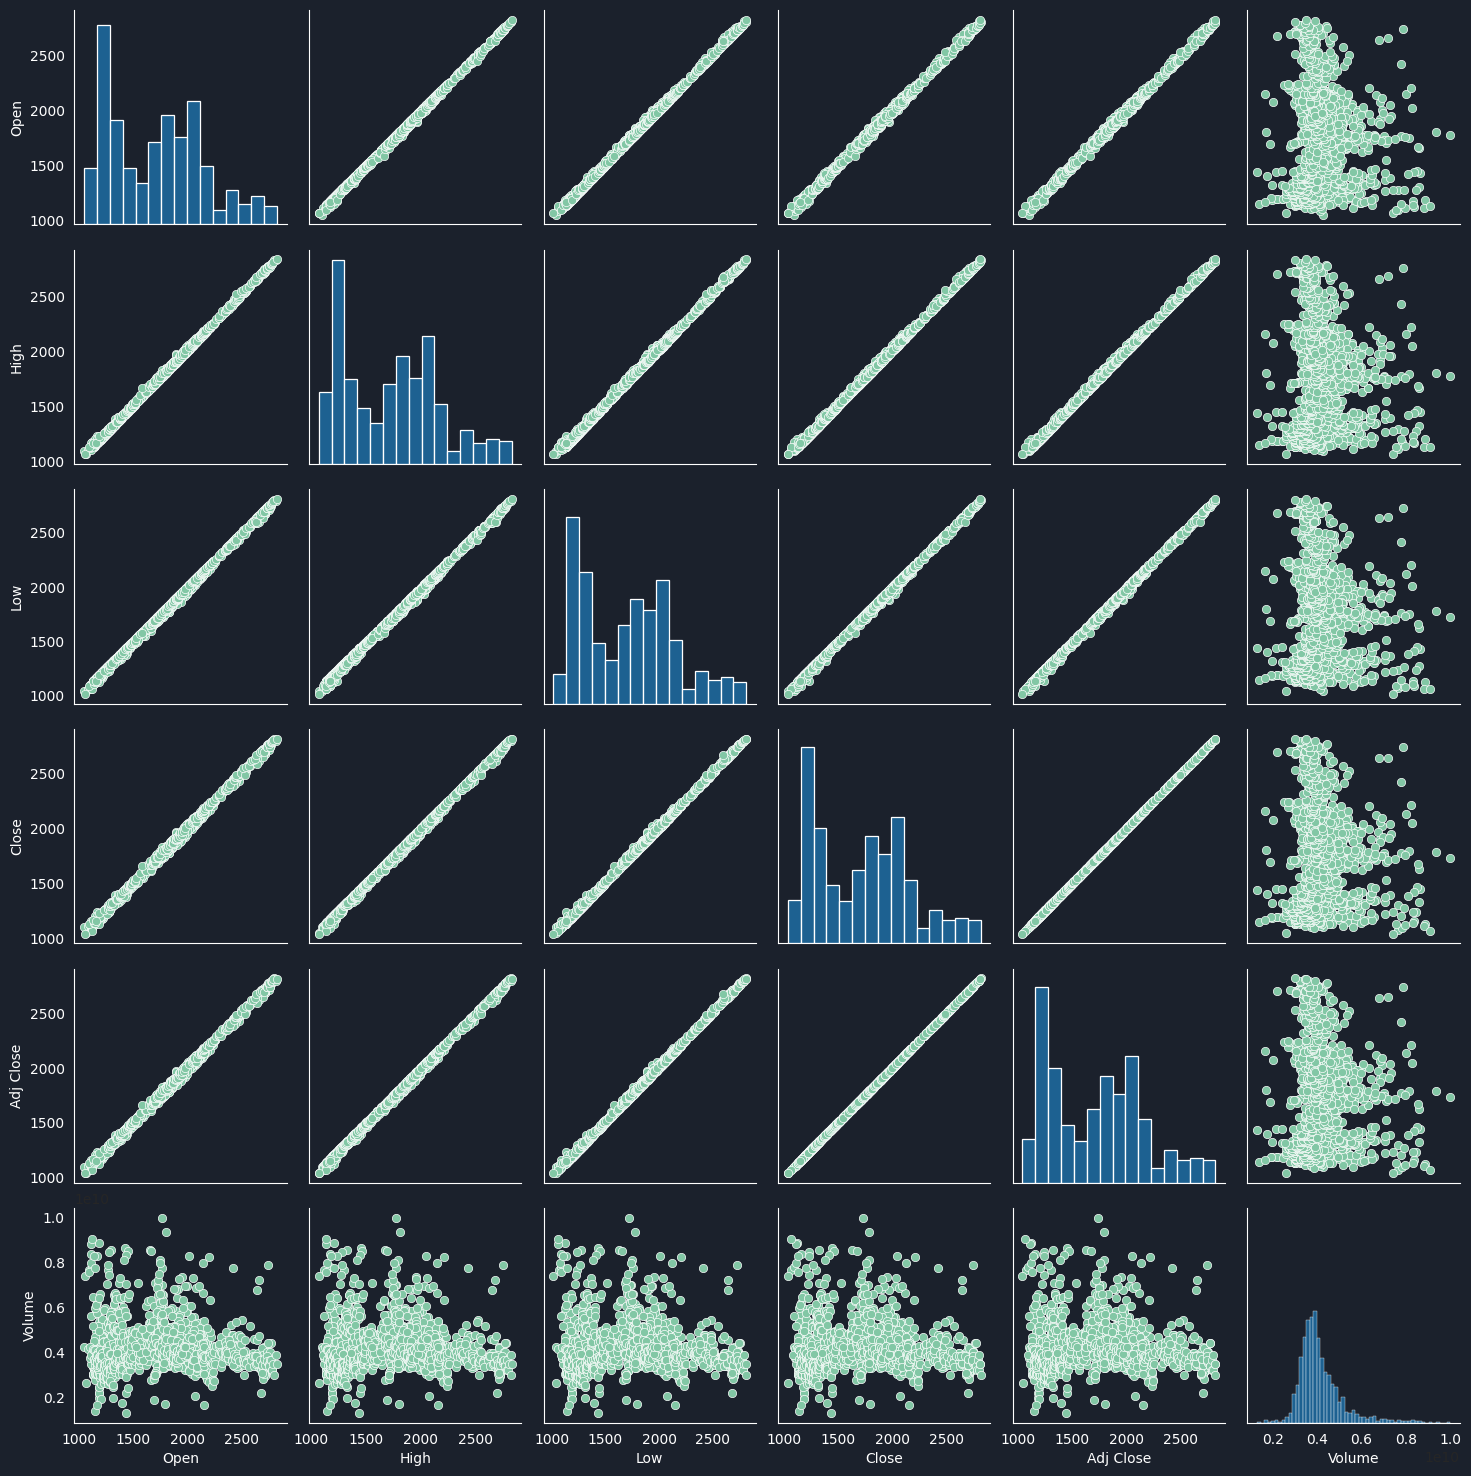

In [ ]:
verde_grafico = ["#82c7a5"]
sns.set_style('darkgrid')
plot = sns.pairplot(df_sp100, plot_kws={'color': '#82c7a5'})


plt.gcf().set_facecolor('#1b212cff')

for ax in plt.gcf().get_axes():
    ax.set_facecolor('#1b212cff')
    for label in ax.get_xticklabels():
        label.set_color('w')
    for label in ax.get_yticklabels():
        label.set_color('w')
    ax.set_xlabel(ax.get_xlabel(), color='w')
    ax.set_ylabel(ax.get_ylabel(), color='w')
    ax.grid(False)

# Pairplot para o Índice IBOV

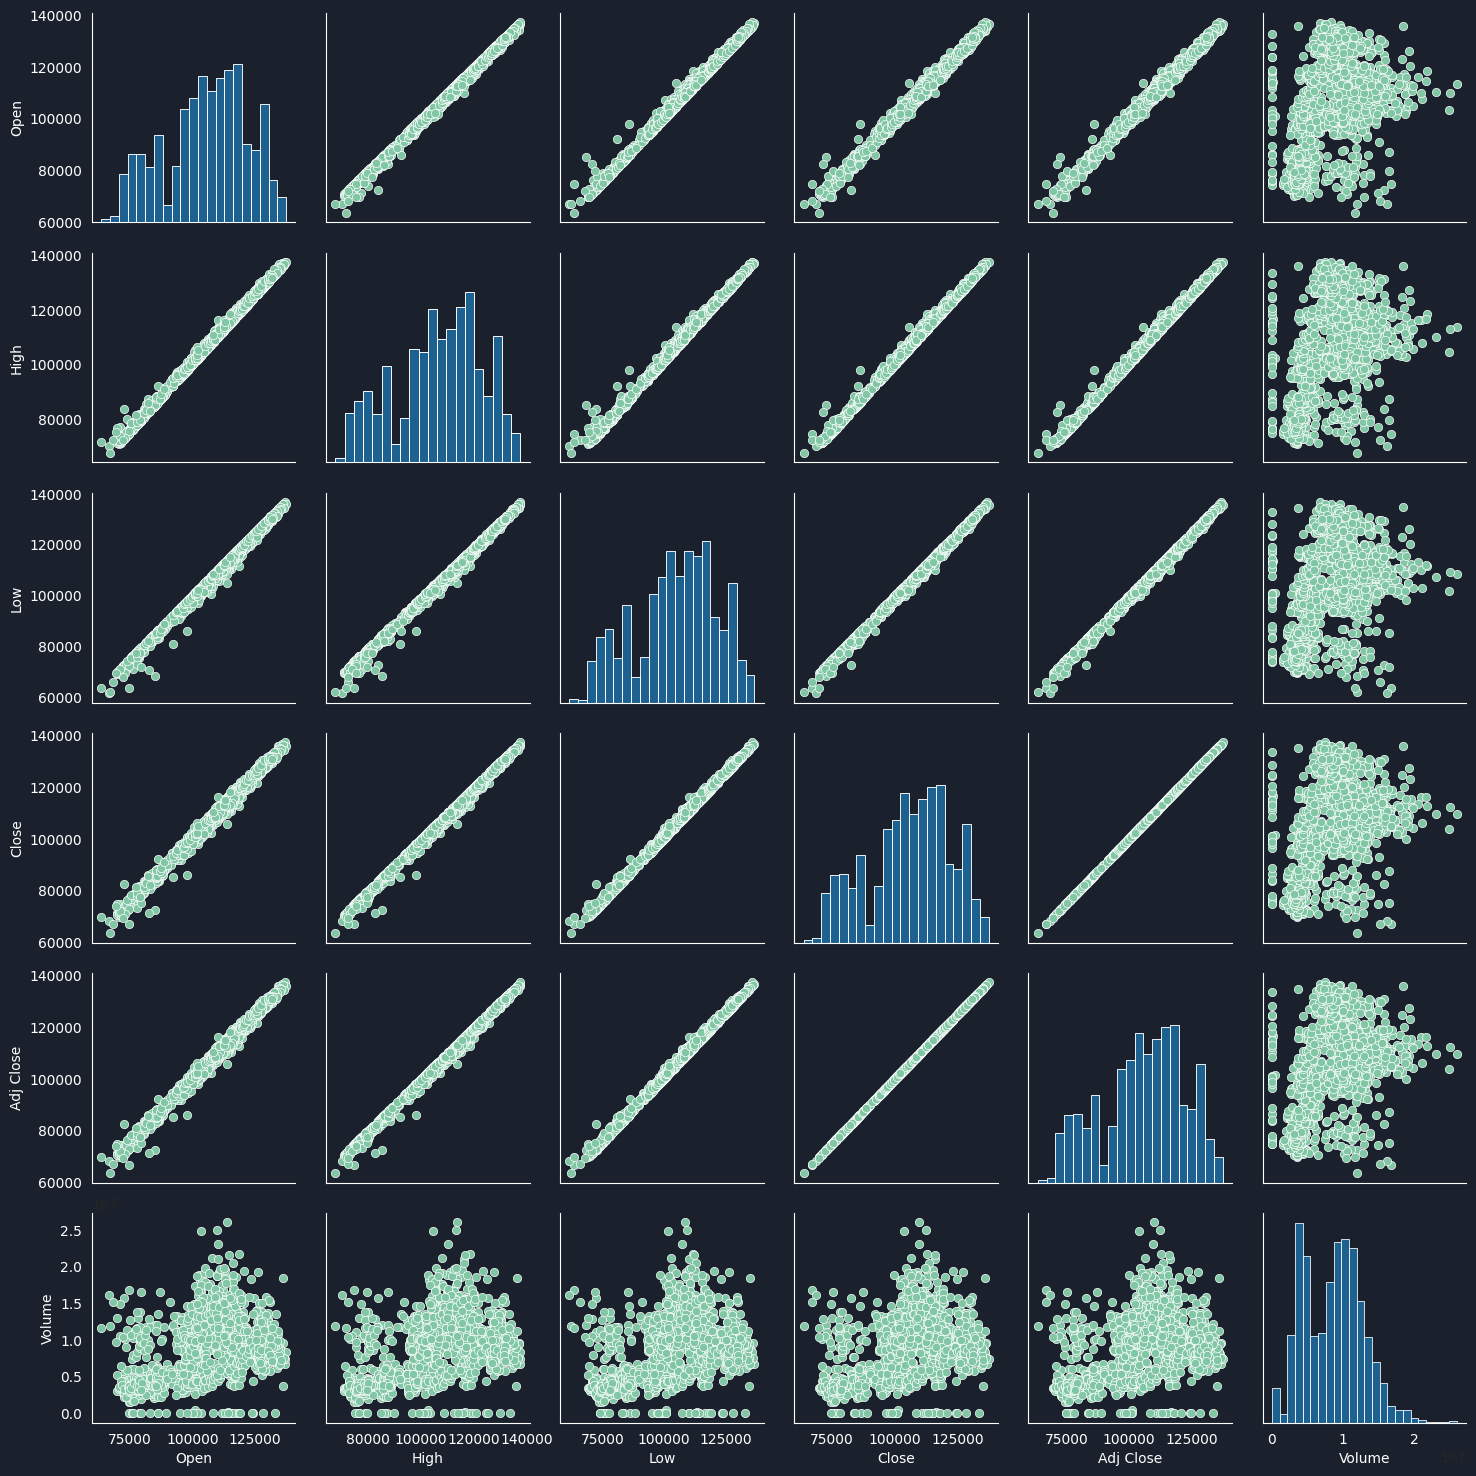

In [ ]:
verde_grafico = ["#82c7a5"]
sns.set_style('darkgrid')
plot = sns.pairplot(df_bvsp, plot_kws={'color': '#82c7a5'})


plt.gcf().set_facecolor('#1b212cff')

for ax in plt.gcf().get_axes():
    ax.set_facecolor('#1b212cff')
    for label in ax.get_xticklabels():
        label.set_color('w')
    for label in ax.get_yticklabels():
        label.set_color('w')
    ax.set_xlabel(ax.get_xlabel(), color='w')
    ax.set_ylabel(ax.get_ylabel(), color='w')
    ax.grid(False)

### Ativos S&P 100

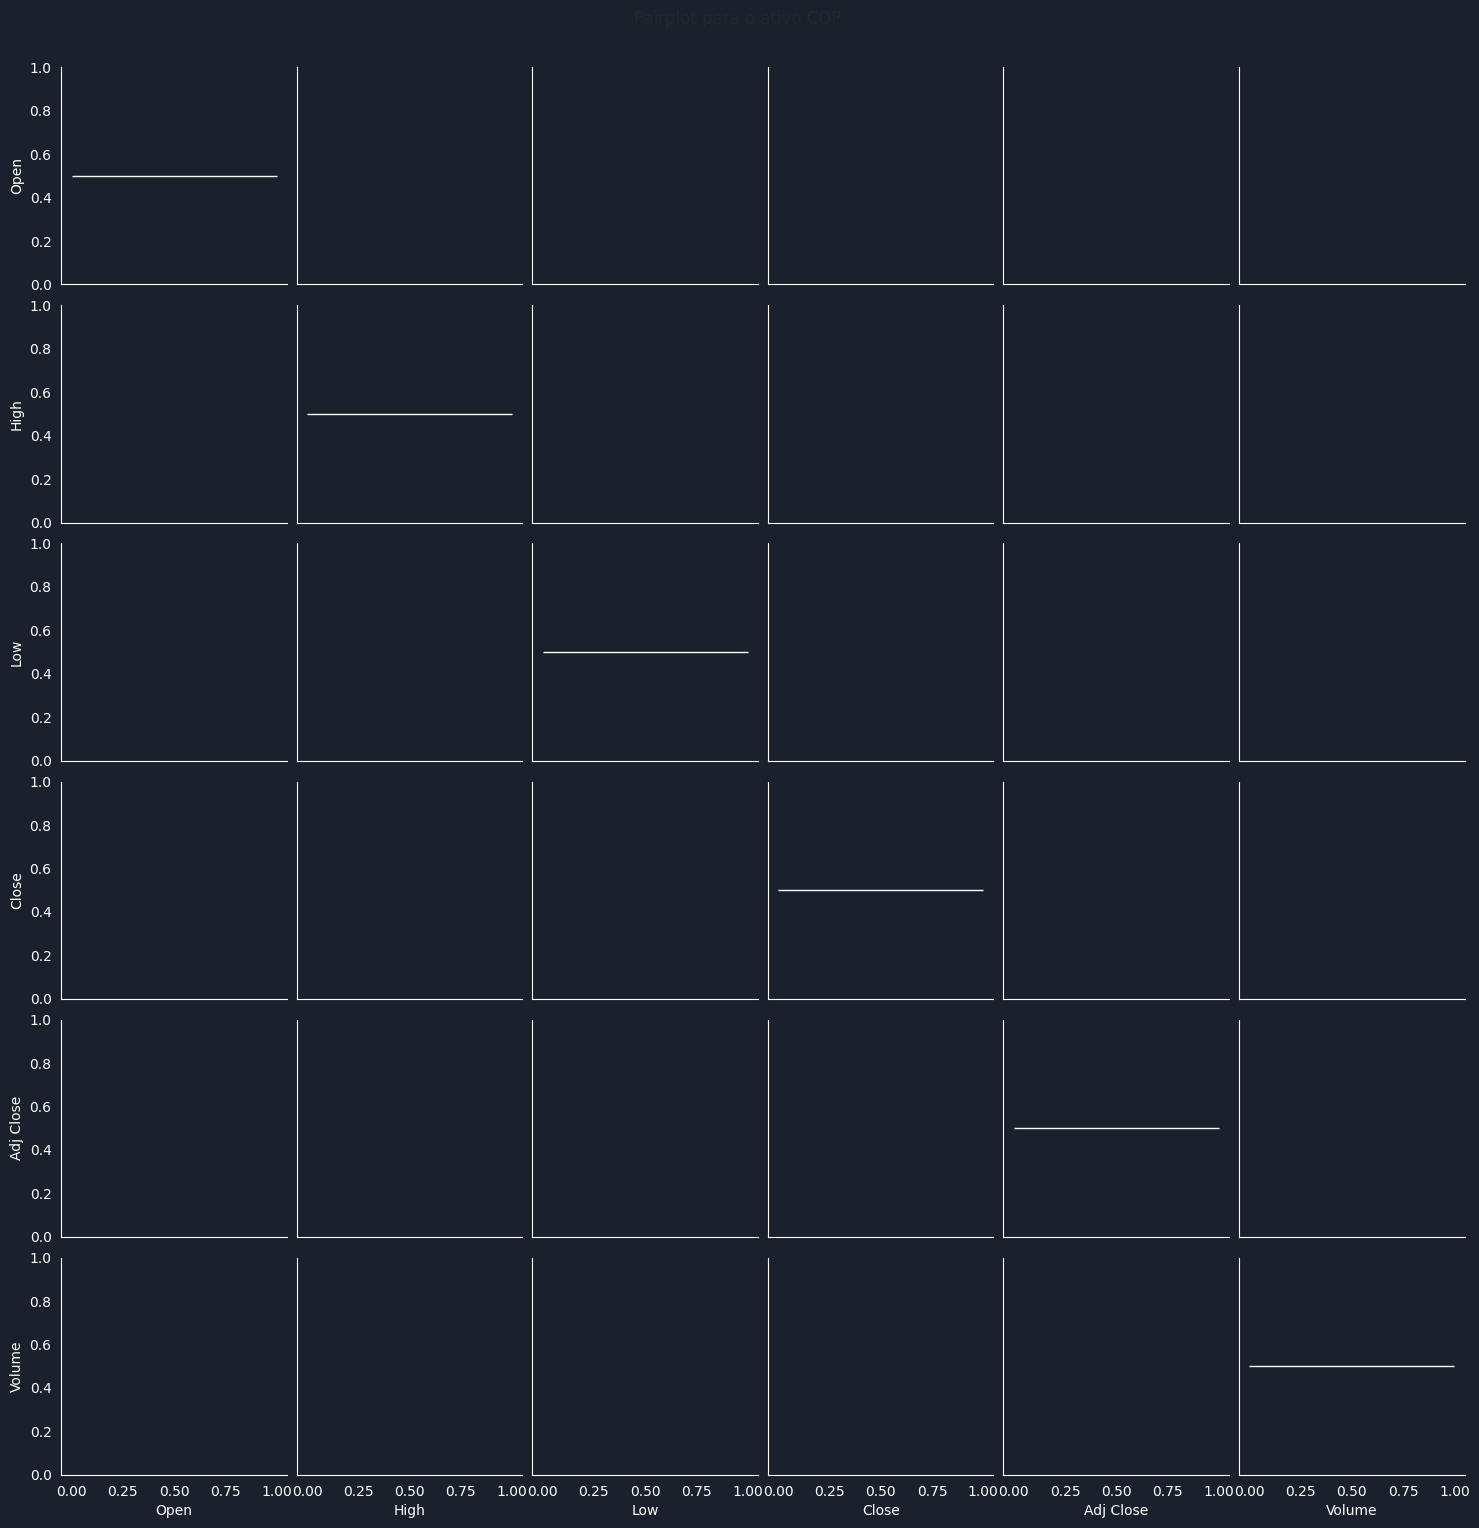

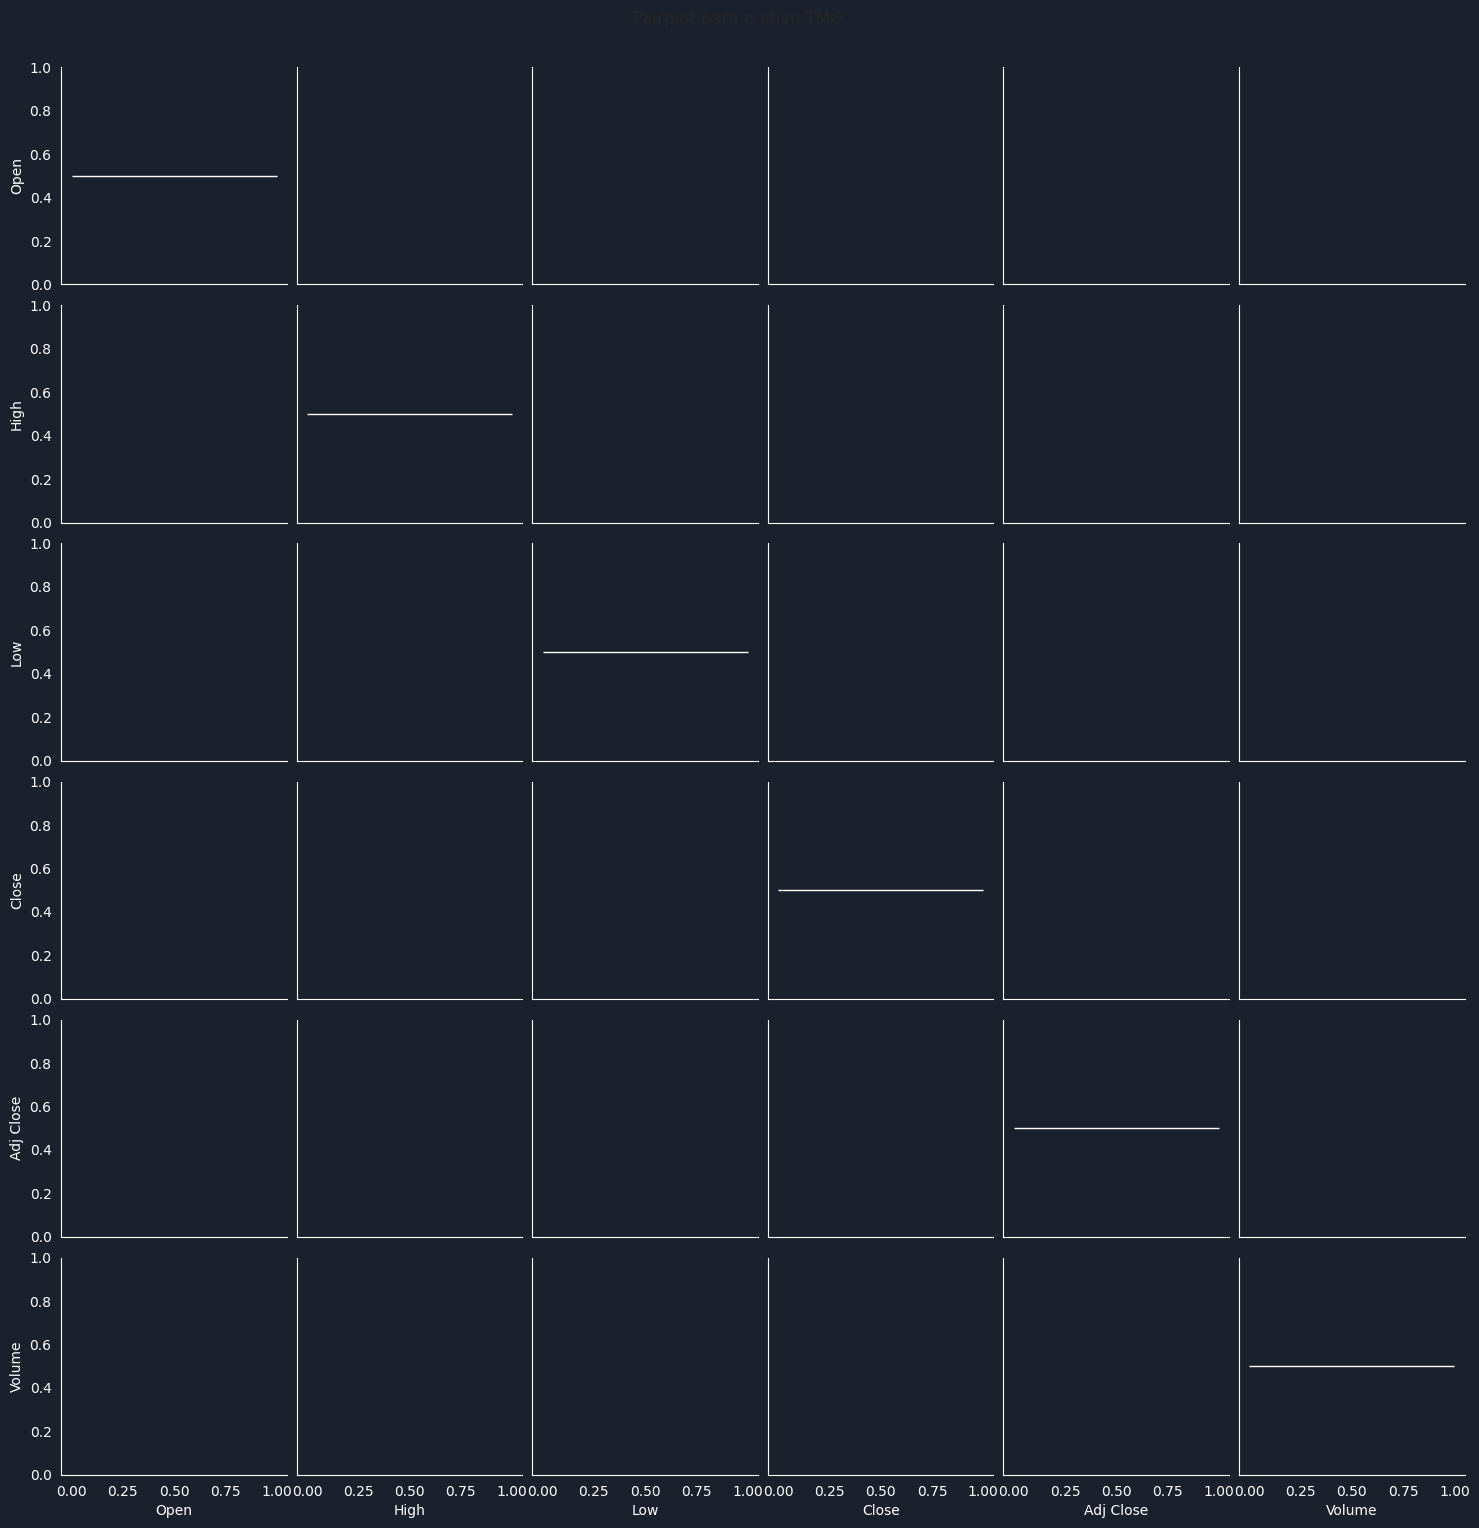

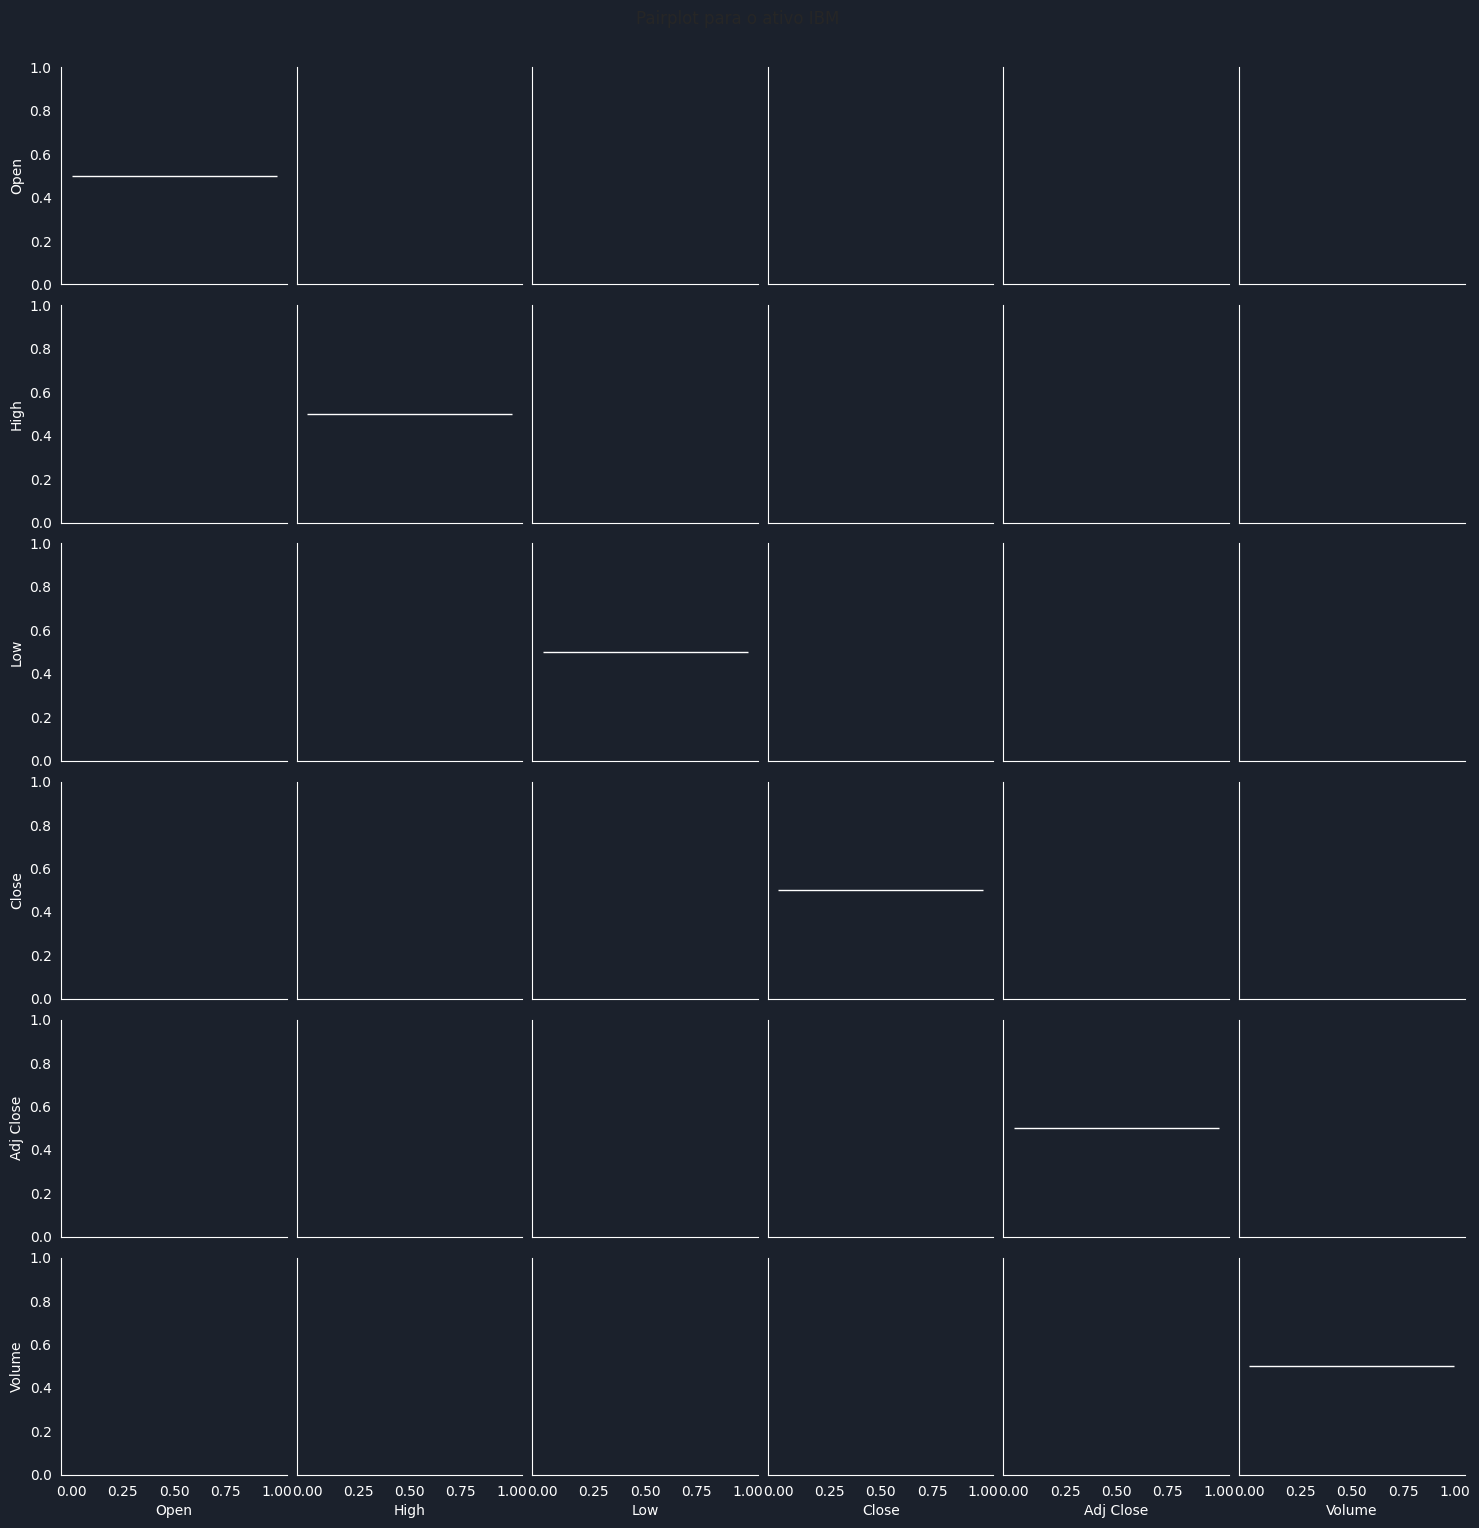

In [ ]:
from random import sample
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')

# Número de ativos sorteados
num_sorteados = 3

# Sorteio dos símbolos únicos do IBOVESPA
sp100_sorteados = sample(list(df_ativos_sp100['Symbol'].unique()), num_sorteados)

# Criar os pairplots para cada ativo sorteado
for simbolo in sp100_sorteados:
    # Filtrar os dados do ativo atual
    df_ativo = df_ativos_sp100[df_ativos_sp100['Symbol'] == simbolo]

    # Selecionar apenas as colunas numéricas relevantes
    df_numerico = df_ativo[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]

    # Criar o pairplot
    pairplot = sns.pairplot(df_numerico, plot_kws={'color': '#82c7a5'})

    # Adicionar título ao gráfico
    pairplot.fig.suptitle(f"Pairplot para o ativo {simbolo}", y=1.02)

    # Mudança de estilo do gráfico

    plt.gcf().set_facecolor('#1b212cff')

    for ax in plt.gcf().get_axes():
        ax.set_facecolor('#1b212cff')
        for label in ax.get_xticklabels():
            label.set_color('w')
        for label in ax.get_yticklabels():
            label.set_color('w')
        ax.set_xlabel(ax.get_xlabel(), color='w')
        ax.set_ylabel(ax.get_ylabel(), color='w')
        ax.grid(False)
        ax.set_title(ax.get_title(), color='w') # tirar que nao faz nada
        legend = plt.gca().get_legend()
        if legend:
            legend.set_facecolor('w')  # tirar que nao faz nada
            legend.set_edgecolor('w')   # Cor da borda da legenda
            for text in legend.get_texts():
                text.set_color('w')

    # Exibir o gráfico
    plt.show()

### Ativos IBOV

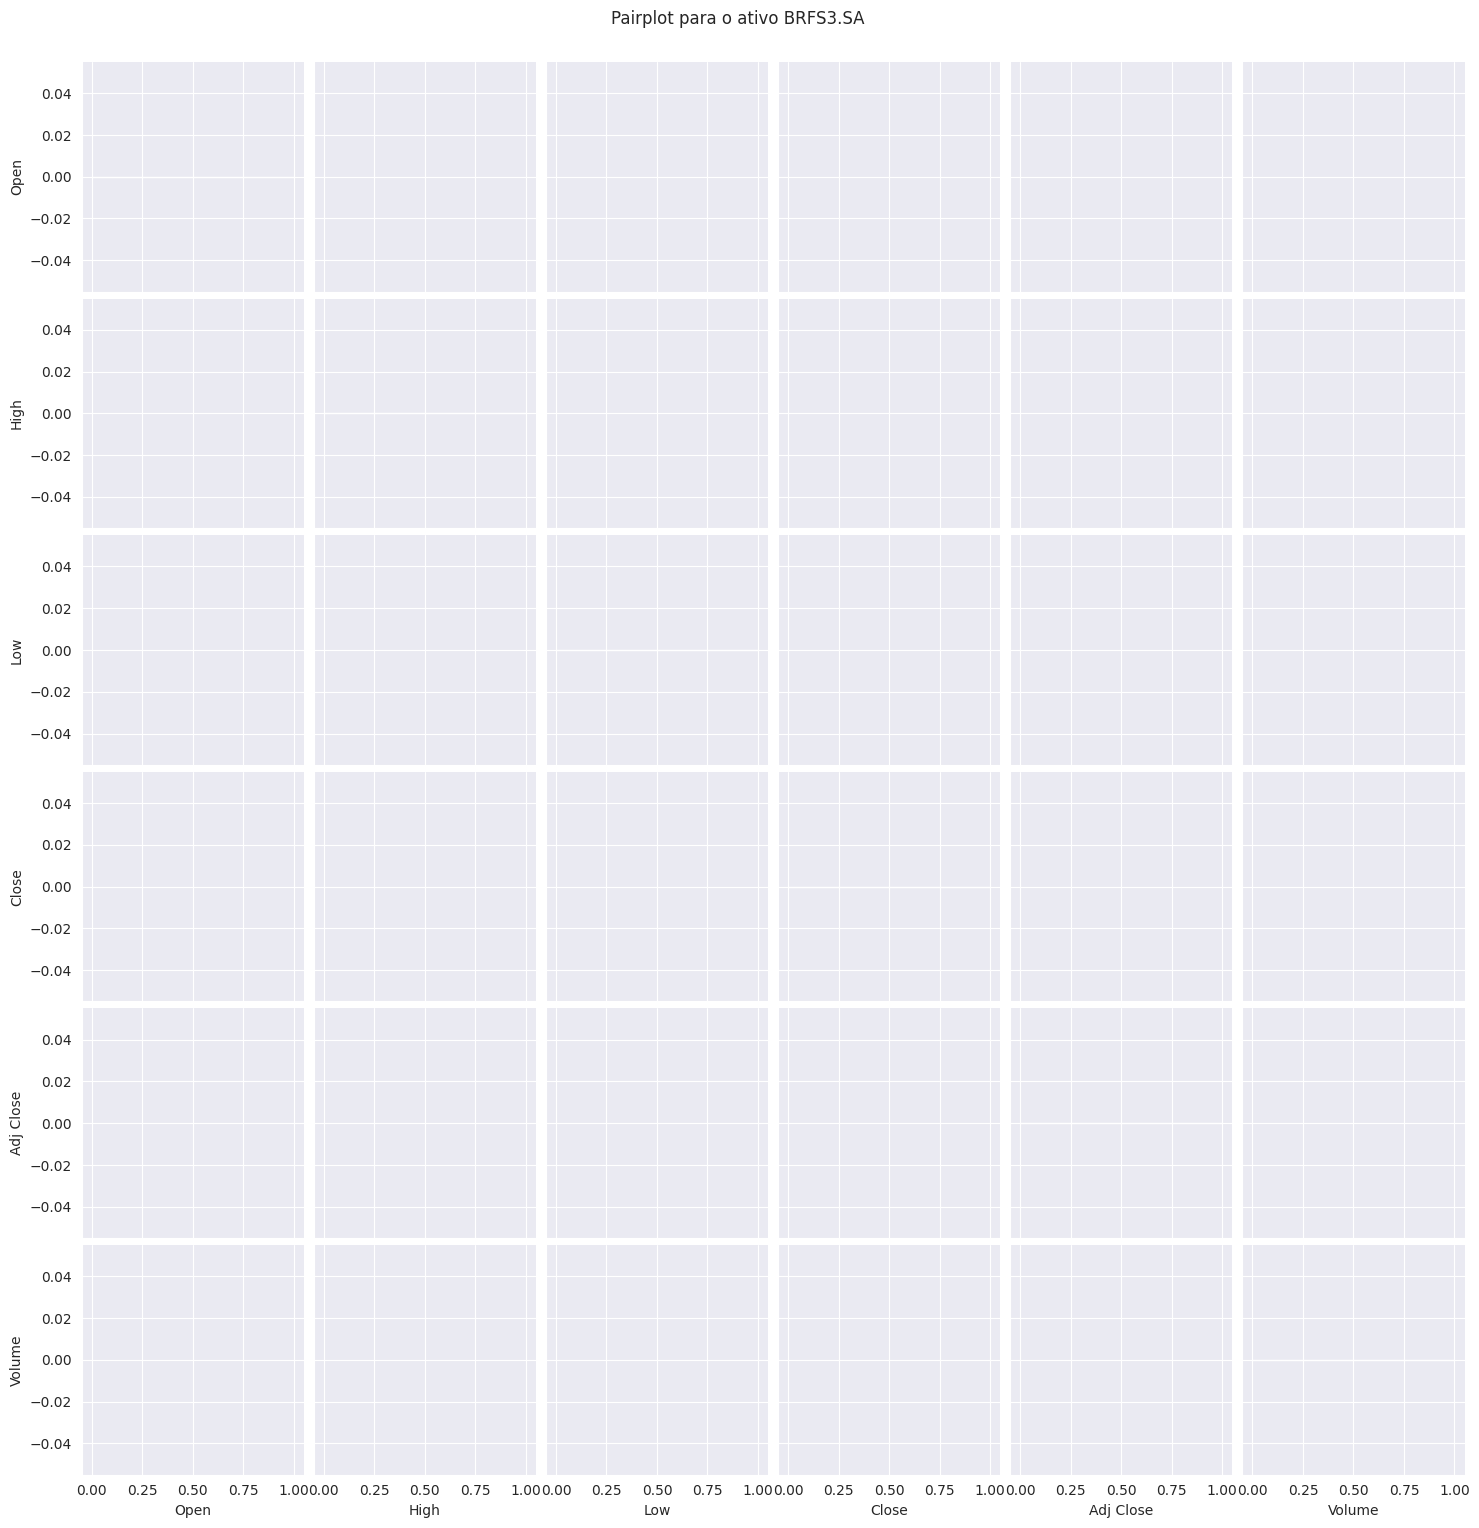

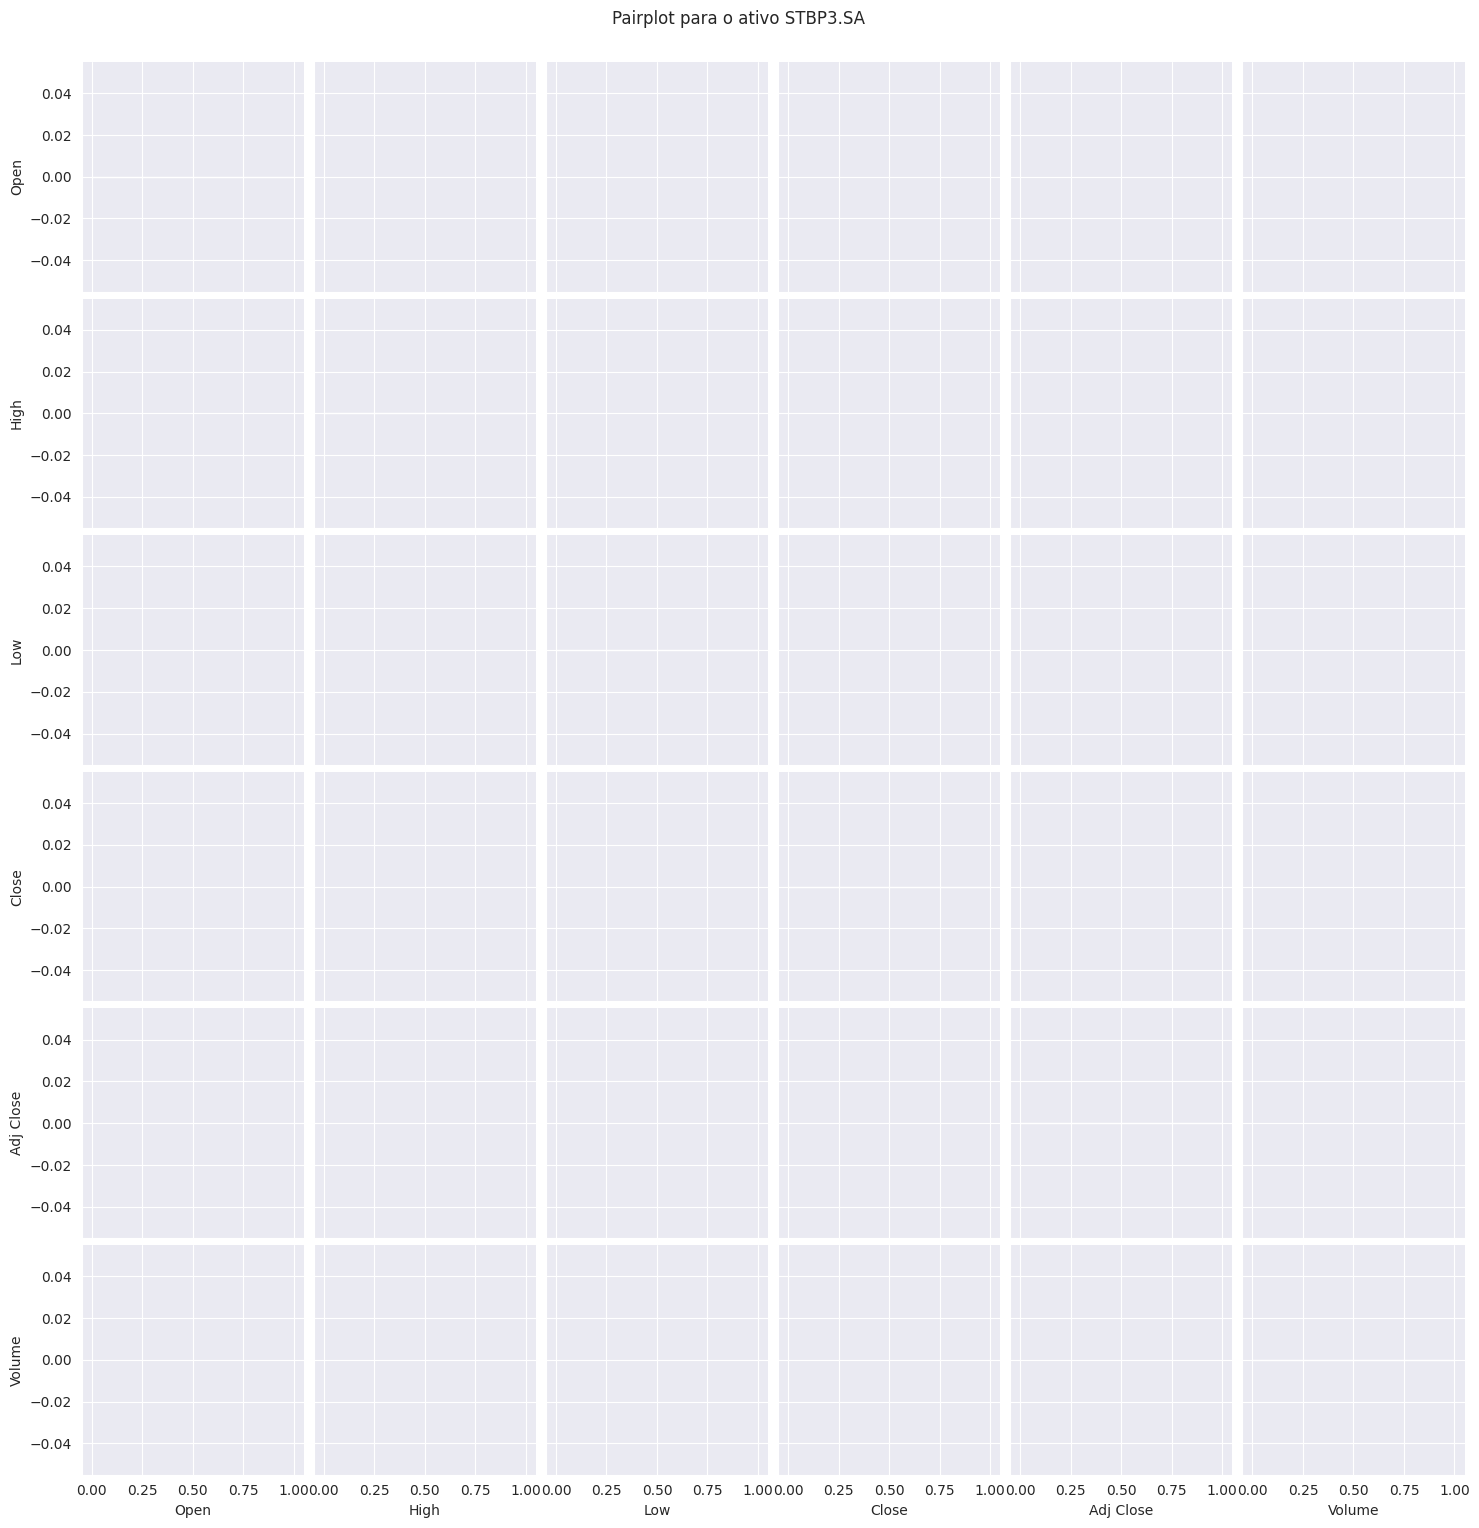

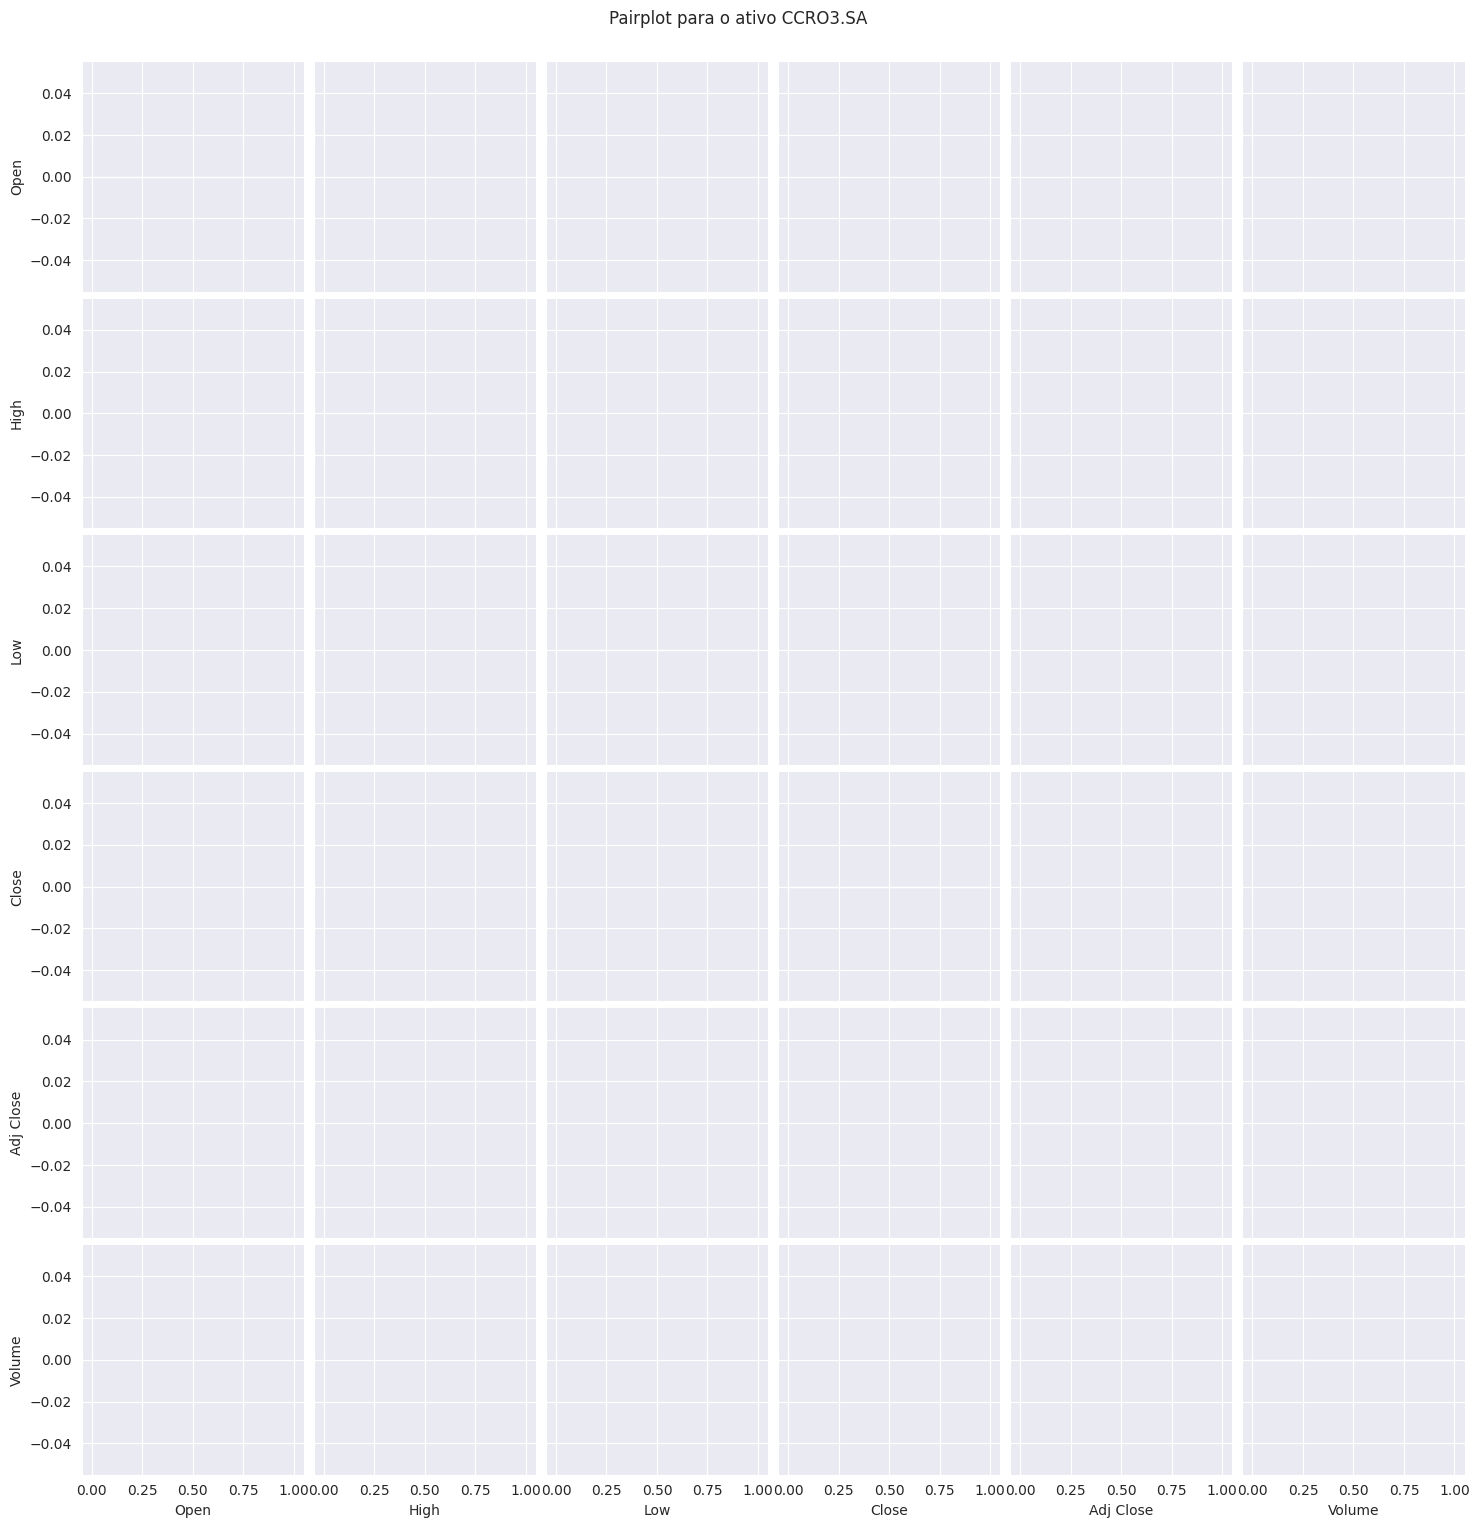

In [ ]:
from random import sample
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Número de ativos sorteados
num_sorteados = 3

# Sorteio dos símbolos únicos do IBOVESPA
bvsp_sorteados = sample(list(df_ativos_bvsp['Symbol'].unique()), num_sorteados)

# Criar os pairplots para cada ativo sorteado
for simbolo in bvsp_sorteados:
    # Filtrar os dados do ativo atual
    df_ativo = df_ativos_bvsp[df_ativos_bvsp['Symbol'] == simbolo]

    # Selecionar apenas as colunas numéricas relevantes
    df_numerico = df_ativo[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]

    # Criar o pairplot
    pairplot = sns.pairplot(df_numerico)

    # Adicionar título ao gráfico
    pairplot.fig.suptitle(f"Pairplot para o ativo {simbolo}", y=1.02)

    # Exibir o gráfico
    plt.show()


## Obtenção dos retornos diários

O modelo de minimização é dado por:

$$ min\frac{1}{T} \sum_{t=1}^{T} \Bigg(\sum_{i \in I} w_{i} r_{t,i} - R_{t}\Bigg)^{2} $$



Abaixo os parâmetros $r_{t,i}$ e $R_{t}$, retorno diário dos ativos e retorno diário do índice respectivamente, são obtidos. De forma geral, o retorno diário, $R_{d}$, pode ser calculado através da seguinte expressão:

$$ R_d = \frac{p_t - p_{t-1}}{p_{t-1}}, $$

onde $p_t$ é o valor do índice ou ativo no dia $t$.

### Retornos diários dos índices

Aqui cálculo do $R_d$ para os índices e criação do dataframe com os retornos que será usado no modelo.

In [ ]:
# Variáveis abaixo recebem os DataFrames que queremos trabalhar
df_bvsp = df_bvsp.copy()
df_sp100 = df_sp100.copy()

# Cálculo do retorno diário dos índices
df_bvsp['Retorno Diario'] = df_bvsp['Adj Close'].pct_change()
df_sp100['Retorno Diario'] = df_sp100['Adj Close'].pct_change()

# Selecionando as colunas desejadas
df_bvsp = df_bvsp[['Date', 'Adj Close', 'Retorno Diario']]
df_sp100 = df_sp100[['Date', 'Adj Close', 'Retorno Diario']]

# Criação do dataframe com os retornos dos índices
df_sp100.to_csv('sp100_retornos.csv', index=False)
df_bvsp.to_csv('bvsp_retornos.csv', index=False)

#df_sp100.head()
#df_bvsp.head()

### Retornos diários dos ativos

Aqui cálculo do $R_d$ para para os ativos de cada índice e criação do dataframe com os retornos que será usado no modelo.

In [ ]:
# Variáveis abaixo recebem os DataFrames que queremos trabalhar
df_ativos_bvsp = df_ativos_bvsp.copy()
df_ativos_sp100 = df_ativos_sp100.copy()

# Cálculo do retorno diário para os ativos, agrupando por símbolo
df_ativos_bvsp['Retorno Diario'] = df_ativos_bvsp.groupby('Symbol')['Adj Close'].pct_change()
df_ativos_sp100['Retorno Diario'] = df_ativos_sp100.groupby('Symbol')['Adj Close'].pct_change()

# Selecionando as colunas desejadas
df_ativos_bvsp = df_ativos_bvsp[['Symbol', 'Date', 'Adj Close', 'Retorno Diario']]
df_ativos_sp100 = df_ativos_sp100[['Symbol', 'Date', 'Adj Close', 'Retorno Diario']]

# Criação do dataframe com os retornos dos ativos
df_ativos_sp100.to_csv('sp100_ativos_retornos.csv', index=False)
df_ativos_bvsp.to_csv('bvsp_ativos_retornos.csv', index=False)

#df_ativos_sp100.head()
#df_ativos_bvsp.head()

<ipython-input-21-72469738f223>:6: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_ativos_bvsp['Retorno Diario'] = df_ativos_bvsp.groupby('Symbol')['Adj Close'].pct_change()


TypeError: unsupported operand type(s) for /: 'str' and 'str'

### Visualização dos retornos diários

Abaixo três visualizações são apresentadas os retornos diários dos índices e um percentual x do total dos ativos que os compõem. A partir da visualização é possível se fazer uma análise qualitativa sobre os cálculos do $R_d$.

In [ ]:
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from random import sample
from itertools import cycle
from matplotlib.ticker import MultipleLocator

##### INPUTS #######

# Definição das datas
inicio = '2017-10-18'
fim = '2024-10-18'

window_size = 21
percentual_ativos = 0.03

# Nome do arquivo da imagem gerada
nome_png = 'comparacao_indices_media_movel.png'

# Conversão das datas para datetime
date_start = pd.Timestamp(inicio)
date_end = pd.Timestamp(fim)

date_start_str = date_start.strftime('%d %b %Y')
date_end_str = date_end.strftime('%d %b %Y')

# Leitura dos dados de retorno dos índices
retornos_sp100 = pd.read_csv('sp100_retornos.csv', parse_dates=['Date'])
retornos_bvsp = pd.read_csv('bvsp_retornos.csv', parse_dates=['Date'])

# Leitura dos dados de retorno dos ativos
retornos_ativos_sp100 = pd.read_csv('sp100_ativos_retornos.csv', parse_dates=['Date'])
retornos_ativos_bvsp = pd.read_csv('bvsp_ativos_retornos.csv', parse_dates=['Date'])

# Filtrando o intervalo de datas nos índices
retornos_sp100 = retornos_sp100[(retornos_sp100['Date'] >= date_start) & (retornos_sp100['Date'] <= date_end)]
retornos_bvsp = retornos_bvsp[(retornos_bvsp['Date'] >= date_start) & (retornos_bvsp['Date'] <= date_end)]

# Filtrando o intervalo de datas nos ativos
retornos_sp100 = retornos_sp100[(retornos_sp100['Date'] >= date_start) & (retornos_sp100['Date'] <= date_end)]
retornos_bvsp = retornos_bvsp[(retornos_bvsp['Date'] >= date_start) & (retornos_bvsp['Date'] <= date_end)]

# Cálculo da média móvel cada índice
retornos_sp100['MediaMovel'] = retornos_sp100['Retorno Diario'].rolling(window=window_size).mean() * 100
retornos_bvsp['MediaMovel'] = retornos_bvsp['Retorno Diario'].rolling(window=window_size).mean() * 100

# Escolhendo aleatoriamente x ativos
num_ativos = int(len(retornos_ativos_sp100['Symbol'].unique()) * percentual_ativos)
sp100_sorteados = sample(list(retornos_ativos_sp100['Symbol'].unique()), num_ativos)
bvsp_sorteados = sample(list(retornos_ativos_bvsp['Symbol'].unique()), num_ativos)

# Customização do plot com subplots
plt.style.use('dark_background')
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 12), sharex=True, facecolor='#1b212cff')  # Cria três subplots (ax1, ax2 e ax3)

# Plot 1: Retornos diários dos índices
ax1.plot(retornos_bvsp['Date'], retornos_bvsp['MediaMovel'], label='IBOV', color='royalblue')
ax1.plot(retornos_sp100['Date'], retornos_sp100['MediaMovel'], label='S&P 100', color='limegreen')
ax1.set_title(f'Retornos Diários [{date_start_str} - {date_end_str}]', loc='left', fontsize=18, pad=15)
ax1.set_ylabel('Retorno Diário (%)', fontsize=14, labelpad=12)
ax1.set_ylim(-3, 2)
ax1.autoscale(enable=True, axis='y')
ax1.yaxis.set_major_locator(MultipleLocator(1.0))
ax1.legend(fontsize=12, loc='best', frameon=False)
ax1.grid(True, alpha=0.2)
ax1.set_facecolor('#1b212cff')

# Adicionando borda ao redor do gráfico
for spine in ax1.spines.values():
    spine.set_visible(True)  # Ativar todas as bordas
    spine.set_edgecolor('white')  # Definir a cor da borda
    spine.set_linewidth(0.5)  # Definir a largura da borda

# Plot 2: Retorno Diário Sorteados do IBOV
cores = cycle(['orange', 'forestgreen', 'maroon', 'royalblue', 'darkmagenta'])
for ativo in bvsp_sorteados:
    # Filtrar os dados do ativo específico
    ativo_data = retornos_ativos_bvsp[retornos_ativos_bvsp['Symbol'] == ativo]

    # Filtrando os dados do ativo no intervalo de datas
    ativo_data = ativo_data[(ativo_data['Date'] >= date_start) & (ativo_data['Date'] <= date_end)]

    # Adicionar média móvel
    ativo_data['MediaMovel'] = ativo_data['Retorno Diario'].rolling(window=window_size).mean() * 100

    cor_atual = next(cores)

    # Plotando o ativo normalizado
    ax2.plot(ativo_data['Date'], ativo_data['MediaMovel'], color=cor_atual, label=f'{ativo}')
    ax2.set_ylabel('Retorno Diário (%)', fontsize=14, labelpad=12)
    ax2.set_ylim(-4, 3)
    ax2.autoscale(enable=True, axis='y')
    ax2.yaxis.set_major_locator(MultipleLocator(1.0))
    ax2.tick_params(axis='y', labelsize=10, length=5)
    ax2.legend(fontsize=12, loc='best', frameon=False)
    ax2.grid(True, alpha=0.2)
    ax2.set_facecolor('#1b212cff')

# Adicionando borda ao redor do gráfico
for spine in ax2.spines.values():
    spine.set_visible(True)  # Ativar todas as bordas
    spine.set_edgecolor('white')  # Definir a cor da borda
    spine.set_linewidth(0.5)  # Definir a largura da borda

# Plot 3: Retorno Diário Sorteados do SP100
for ativo in sp100_sorteados:
    # Filtrar os dados do ativo específico
    ativo_data = retornos_ativos_sp100[retornos_ativos_sp100['Symbol'] == ativo]

    # Filtrando os dados do ativo no intervalo de datas
    ativo_data = ativo_data[(ativo_data['Date'] >= date_start) & (ativo_data['Date'] <= date_end)]

    # Adicionar média móvel
    ativo_data['MediaMovel'] = ativo_data['Retorno Diario'].rolling(window=window_size).mean() * 100

    cor_atual = next(cores)

    # Plotando o ativo normalizado
    ax3.plot(ativo_data['Date'], ativo_data['MediaMovel'], color=cor_atual, label=f'{ativo}')
    ax3.set_ylabel('Retorno Diário (%)', fontsize=14, labelpad=12)
    ax3.set_ylim(-4, 3)
    ax3.autoscale(enable=True, axis='y')
    ax3.yaxis.set_major_locator(MultipleLocator(1.0))
    ax3.tick_params(axis='y', labelsize=10, length=5)
    ax3.legend(fontsize=12, loc='best', frameon=False)
    ax3.grid(True, alpha=0.2)
    ax3.set_facecolor('#1b212cff')

# Adicionando borda ao redor do gráfico
for spine in ax3.spines.values():
    spine.set_visible(True)  # Ativar todas as bordas
    spine.set_edgecolor('white')  # Definir a cor da borda
    spine.set_linewidth(0.5)  # Definir a largura da borda

# Definição dos ticks principais nos anos
ax3.xaxis.set_major_locator(mdates.YearLocator())          # Colocar tick a cada ano
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Formato para mostrar apenas o ano

# Definição dos ticks secundários nos meses de abril, julho e outubro
ax3.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[4, 7, 10]))  # Colocar tick em abril, julho, outubro
ax3.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))             # Mostrar meses abreviados (abr, jul, out)

# Rotação do xticks
ax3.tick_params(axis='x', rotation=45)

# Definição do intervalo de datas
ax1.set_xlim(date_start, date_end)

#ax1.annotate(r'$\left(\frac{\delta_t}{\delta_0} - 1\right) \times 100$', xy=(0.32, 0.6), xycoords='axes fraction', fontsize=22, color='white', ha='left')
#ax2.annotate(r'$\left(\frac{\delta_t}{\delta_{t-1}} - 1\right) \times 100$', xy=(0.45, 0.2), xycoords='axes fraction', fontsize=22, color='white', ha='left')
#ax3.annotate(r'$\sqrt{\frac{\sum_{t=1}^{n}(\delta_t - \overline{\delta})^2}{n - 1}}$', xy=(0.48, 0.35), xycoords='axes fraction', fontsize=22, color='white', ha='left')

# Ajuste do espaçamento entre os subplots
plt.tight_layout()

# Salvar a figura
plt.savefig(nome_png, dpi=300, facecolor='#1b212cff')

## Construção do modelo

### Definição da carteira

Construímos a carteira selecionando aleatoriamente um número de ativos do índice, correspondente a um percentual previamente definido.

In [ ]:
import pandas as pd
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter, MultipleLocator
from random import choice

# Define o percentual que a carteira representa do índice
percentual_ativos = 0.01

# Definição das datas
inicio = '2017-10-18'
fim = '2017-12-18'

# Conversão das datas para datetime
date_start = pd.Timestamp(inicio)
date_end = pd.Timestamp(fim)

# Leitura dos dados de retorno dos índices e ativos
retornos_sp100 = pd.read_csv('sp100_retornos.csv', parse_dates=['Date'])
retornos_bvsp = pd.read_csv('bvsp_retornos.csv', parse_dates=['Date'])
retornos_ativos_sp100 = pd.read_csv('sp100_ativos_retornos.csv', parse_dates=['Date'])
retornos_ativos_bvsp = pd.read_csv('bvsp_ativos_retornos.csv', parse_dates=['Date'])

# Filtrando o intervalo de datas nos índices
retornos_sp100 = retornos_sp100[(retornos_sp100['Date'] >= date_start) & (retornos_sp100['Date'] <= date_end)]
retornos_bvsp = retornos_bvsp[(retornos_bvsp['Date'] >= date_start) & (retornos_bvsp['Date'] <= date_end)]

# Função para selecionar uma ação com dados no intervalo de datas
def escolher_acao_com_dados(retornos_ativos, date_start, date_end):
    while True:
        acao = choice(retornos_ativos['Symbol'].unique())  # Escolhe uma ação aleatória
        dados_acao = retornos_ativos[(retornos_ativos['Symbol'] == acao) &
                                     (retornos_ativos['Date'] >= date_start) &
                                     (retornos_ativos['Date'] <= date_end)]
        if not dados_acao.empty:  # Verifica se há dados no intervalo de datas
            return acao

# Construção da carteira
num_ativos = int(len(retornos_ativos_sp100['Symbol'].unique()) * percentual_ativos)

# Selecionar ativos com dados no período para SP100 e BVSP
sp100_sorteados = [escolher_acao_com_dados(retornos_ativos_sp100, date_start, date_end) for _ in range(num_ativos)]
bvsp_sorteados = [escolher_acao_com_dados(retornos_ativos_bvsp, date_start, date_end) for _ in range(num_ativos)]

print("Ações sorteadas SP100:", sp100_sorteados)
print("Ações sorteadas BVSP:", bvsp_sorteados)

# Criar arrays para armazenar os dados de cada ativo
dados_sp100_ativos_sorteados = []
dados_bvsp_ativos_sorteados = []

# Preencher os arrays com os dados dos ativos sorteados
for acao in sp100_sorteados:
    dados_acao = retornos_ativos_sp100[(retornos_ativos_sp100['Symbol'] == acao) &
                                       (retornos_ativos_sp100['Date'] >= date_start) &
                                       (retornos_ativos_sp100['Date'] <= date_end)]
    dados_sp100_ativos_sorteados.append(dados_acao)

for acao in bvsp_sorteados:
    dados_acao = retornos_ativos_bvsp[(retornos_ativos_bvsp['Symbol'] == acao) &
                                      (retornos_ativos_bvsp['Date'] >= date_start) &
                                      (retornos_ativos_bvsp['Date'] <= date_end)]
    dados_bvsp_ativos_sorteados.append(dados_acao)

# Exibir os dados de cada ativo
print("\nDados dos ativos sorteados SP100:")
#for idx, dados_acao in enumerate(dados_sp100_ativos_sorteados):
#    print(f"\nDados do ativo {sp100_sorteados[idx]} (SP100):")
#    print(dados_acao.head())

print("\nDados dos ativos sorteados BVSP:")
#for idx, dados_acao in enumerate(dados_bvsp_ativos_sorteados):
#    print(f"\nDados do ativo {bvsp_sorteados[idx]} (BVSP):")
#    print(dados_acao.head())


In [ ]:
#dados_bvsp_ativos_sorteados[0].head(1000)
#dados_sp100_ativos_sorteados[0].head()
retornos_sp100.head()

In [ ]:
import numpy as np
import pandas as pd

pesos = np.random.dirichlet(alpha=[1] * num_ativos)
print("Pesos dos ativos:", pesos, np.sum(pesos))

retornos_ponderados = []

R_t = retornos_sp100['Retorno Diario']
for i in range(num_ativos):
    r_i_t = dados_sp100_ativos_sorteados[i]['Retorno Diario'] * pesos[i]

    retornos_ponderados.append(r_i_t)

retorno_carteira = np.sum(retornos_ponderados, axis=0)
resultado = retorno_carteira - R_t
# Exibir os resultados
#print("Pesos dos ativos:", pesos, np.sum(pesos))
#print("\nRetorno da carteira menos retorno do índice:")
#print(resultado)

# Teste do Modelo com Gurobi

In [ ]:
import gurobipy as grb

# Modelo Matemático - Restrições

1. **Soma dos pesos igual a 1**:
   
   $\sum_{i \in I} w_i = 1$
   
   Garante que o portfólio seja totalmente alocado.

2. **Pesos não negativos**:
   
   $w_i \geq 0 \quad \forall i \in I$


  Os pesos não podem ser negativos (proibição de posições vendidas).

3. **Pesos limitados pela variável binária**:
   
   $w_i \leq z_i \quad \forall i \in I$

   Controla os pesos com base em uma variável binária ($z_i$), que indica se o ativo está incluído no portfólio ($z_i = 1$) ou não ($z_i = 0$).

4. **Variável binária**:
   
   $
   z_i \in \{0, 1\} \quad \forall i \in I
   $
   Define a presença ($z_i = 1$) ou ausência ($z_i = 0$) de um ativo no portfólio.

5. **Limite no número de ativos**:
   
   $
   \sum_{i \in I} z_i \leq K
   $

   Restringe o portfólio a no máximo \(K\) ativos.



```

```



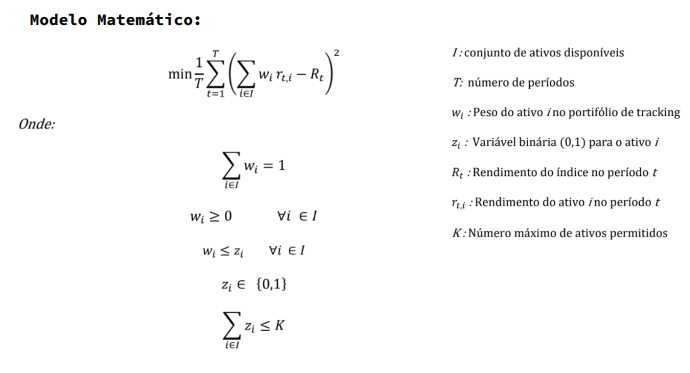

In [ ]:
 retorno_sp100_modelo = df_sp100['Retorno Diario'].tolist()

In [ ]:
df_sp100['Retorno Diario']

# Criando as variáveis do modelo SP_100


In [ ]:
df_ativos_sp100.nunique()[0]

In [ ]:
from datetime import datetime
from gurobipy import GRB

#Objetivo -- error tracking em 5%
error = 0.05

#Criando o modelo
modelo = grb.Model('modelo_carteira')

#Define o conjunto de ativos disponíveis na carteira
numero_ativos_sp100 = df_ativos_sp100.nunique()[0]
I = modelo.addVar(numero_ativos_sp100, name='conjunto_ativos_disponiveis')

#Define o número de períodos(dias) que compõe o indice
inicio = datetime(2017,10,18)
fim = datetime(2024,10,18)
dias = fim - inicio

T = modelo.addVar(dias.days, name = "Numero_periodos")

#Define Peso para cada ativo
Wi = modelo.addVars(range(df_ativos_sp100.nunique()[0]),vtype=GRB.CONTINUOUS,name="Peso_ativo")
modelo.addConstr(Wi.sum()== 1, name = "Soma_Pesos_1" )



#Define Variável binária para cada ativo (0 - Não presente na carteira, 1- presente na carteira)
Zi = modelo.addVar(vtype=grb.GRB.BINARY, name= "Variave_Bi_Ativo")


#Define o rendimento do índice no período t
Rendimento = modelo.addVars(retorno_sp100_modelo, vtype=GRB.CONTINUOUS, name="Rendimento_Indice_t")
Retorno_T  = modelo.addConstr(Rendimento[T])
#Define o rendimento do ativo i no período t
rt = modelo.addVar(lb=0, name="Rendimento_Ativo_t")

#Define o número de ativos na carteira modelo
K = modelo.addVar(lb=0,name="Numero_Ativos_Max_Carteira")

In [ ]:
dias.days

In [ ]:
#criando as restrioções do modelo matemático
modelo.addConstr(Wi>= 0,"Pesos_Nao_Negativos")
modelo.addConstr(Wi<= Zi,"Controle_Pesos_Binario")
modelo.addConstr(I * Zi <= K,"Numero_de_ativos_max")
